## Classification Neural Network PyTorch

In [1]:
import pandas as pd
import sklearn
from sklearn.datasets import make_circles

### EDA

In [2]:
n_samples = 1000
X, y = make_circles(n_samples, noise=0.03, random_state=42)
print(f"First 5 samples of X: {X[:5]}")
print(f"First 5 samples of y: {y[:5]}")

First 5 samples of X: [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of y: [1 1 1 1 0]


In [3]:
circles = pd.DataFrame({"X1":X[:,0], "X2" : X[:,1], "label" : y})

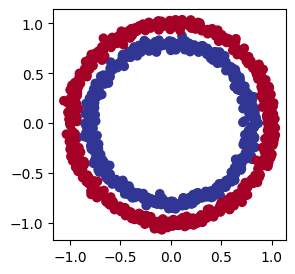

In [4]:
import matplotlib.pyplot as plt
plt.figure(figsize=(3,3))
plt.scatter(x=X[:,0], y=X[:,1], c=y, cmap = plt.cm.RdYlBu)

In [5]:
# shapes checking
X.shape, y.shape

((1000, 2), (1000,))

In [6]:
# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

NameError: name 'torch' is not defined

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from torch import nn
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
# Construct a model
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        # self.l1 = nn.Linear(in_features = 2, out_features=5)
        # self.l2 = nn.Linear(in_features = 5, out_features=1)
        self.l3 = nn.Sequential(
            nn.Linear(in_features=2, out_features=10),
            nn.Linear(in_features=10, out_features=64),
            nn.Linear(in_features=64, out_features=128),
            nn.Linear(in_features=128, out_features=64),
            nn.Linear(in_features=64, out_features=1)
        )
    def forward(self, x):
        # z = self.l1(x)
        # z = self.l2(z)
        # return z
        # return self.l2(self.l1(x))
        return self.l3(x)
model = CircleModelV1().to(device)
print(model)
next(model.parameters()).device

CircleModelV1(
  (l3): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): Linear(in_features=10, out_features=64, bias=True)
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
)


device(type='cuda', index=0)

In [ ]:
with torch.inference_mode():
    untrained_pred = model(X.to(device))
print(len(untrained_pred), untrained_pred.shape)
print(len(X_test), X_test.shape)

1000 torch.Size([1000, 1])
200 torch.Size([200, 2])


In [ ]:
# loss func and optimizer
# loss_fn = nn.BCELoss() requires inputs to have gone through the sigmoid activation function prior to input to BCELoss
# nn.Sequential( This is similar to nn.BCEWithLogitsLoss() (helps in numeric stability)
#     nn.Sigmoid(),
#     nn.BCELoss()
# )
loss_fn = nn.BCEWithLogitsLoss() #(has sigmoid activation function build in)
import torch.optim as optim
optimizer = optim.Adam(params=model.parameters(), lr = 0.1)

# eval metric (accuracy)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_pred)) * 100
    return acc

### Going from raw logits -> predition prob (pass logits to sigmoid(or any act fn)) -> pred probabilites to labels(round or argmax)

In [ ]:
model.eval()
with torch.inference_mode():
    y_logits = model(X_test.to(device))[:5]
y_logits

y_test[:5] # not same format in logits and test labels
#using sigmoid to turn logits into probabilities
y_pred_probs = torch.sigmoid(y_logits)

In [ ]:
y_pred = torch.round(y_pred_probs)
# for pred prob values, perform range-style rounding (decision boundary <=0.5)
y_preds_labels = torch.round(torch.sigmoid(model(X_test.to(device))[:5]))
print(torch.eq(y_pred.squeeze(), y_preds_labels.squeeze()))
y_pred.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([1., 1., 0., 1., 0.], device='cuda:0')

In [ ]:
# Building train test loop
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)


for epoch in range(epochs):
    model.train()
    # Forward pass
    y_logits = model(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    # Calculate accuracy
    loss = loss_fn(y_logits, y_train) # BCEwithlogitsloss expects raw logtis for input (more numerically stable)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    # Optimizer zero grad
    optimizer.zero_grad()

    # Loss backward
    loss.backward()
    
    # Optimizer step
    optimizer.step()

    model.eval()
    with torch.inference_mode():
        # Forward pass
        test_logits = model(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # Calculate Test loss/acc
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | loss: {loss:.5f}, Acc: {acc:.2f} | Test Loss: {test_loss:.5f} | Test Acc: {test_acc:.5f}" ,)

Epoch: 0 | loss: 0.69402, Acc: 47.12 | Test Loss: 6.22544 | Test Acc: 50.00000
Epoch: 100 | loss: 0.69308, Acc: 49.38 | Test Loss: 0.69433 | Test Acc: 46.00000


Epoch: 200 | loss: 0.69298, Acc: 51.12 | Test Loss: 0.69468 | Test Acc: 46.00000
Epoch: 300 | loss: 0.69298, Acc: 51.00 | Test Loss: 0.69468 | Test Acc: 46.00000
Epoch: 400 | loss: 0.69298, Acc: 51.00 | Test Loss: 0.69468 | Test Acc: 46.00000
Epoch: 500 | loss: 0.69298, Acc: 51.00 | Test Loss: 0.69468 | Test Acc: 46.00000
Epoch: 600 | loss: 0.69298, Acc: 51.00 | Test Loss: 0.69468 | Test Acc: 46.00000
Epoch: 700 | loss: 0.69298, Acc: 51.00 | Test Loss: 0.69468 | Test Acc: 46.00000
Epoch: 800 | loss: 0.69298, Acc: 51.00 | Test Loss: 0.69468 | Test Acc: 46.00000
Epoch: 900 | loss: 0.69298, Acc: 51.00 | Test Loss: 0.69468 | Test Acc: 46.00000


### Make preds to eval model

In [ ]:
import requests
from pathlib import Path

# download helper fns 
if Path("helper_functions.py").is_file():
    print("Exists")
else:
    print("Downloading Helper Functions script")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

Exists


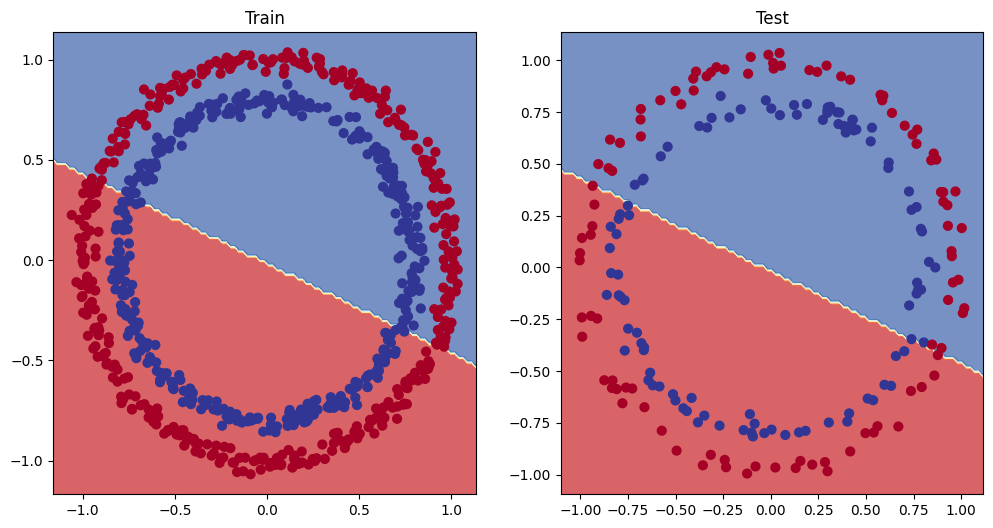

In [ ]:
# Plot Decision boundary of model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1) # row col index
plt.title("Train")
plot_decision_boundary(model, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, X_test, y_test)

#### Improving a model [changes = (more layers / more hidden units / fit for longer / activation fn / learning rate / loss fn)]

In [ ]:
# Troubleshooting
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias

train_split = int(0.8 * len(X_regression))
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

len(X_train_regression), len(y_train_regression), len(X_test_regression), len(y_test_regression)

(80, 80, 20, 20)

Epoch: 0 | Loss: 0.75986 | Test Loss: 0.54143
Epoch: 100 | Loss: 0.09309 | Test Loss: 0.02901
Epoch: 200 | Loss: 0.07376 | Test Loss: 0.02850
Epoch: 300 | Loss: 0.06745 | Test Loss: 0.00615
Epoch: 400 | Loss: 0.06107 | Test Loss: 0.02004
Epoch: 500 | Loss: 0.05698 | Test Loss: 0.01061
Epoch: 600 | Loss: 0.04857 | Test Loss: 0.01326
Epoch: 700 | Loss: 0.06109 | Test Loss: 0.02127
Epoch: 800 | Loss: 0.05599 | Test Loss: 0.01426
Epoch: 900 | Loss: 0.05571 | Test Loss: 0.00603


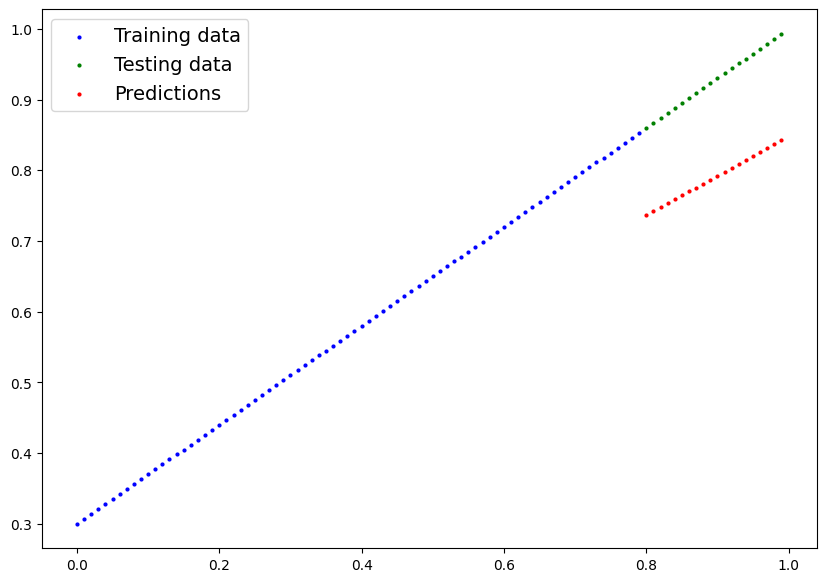

In [ ]:
model2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)

loss_fn2 = nn.L1Loss()
optmizer2 = torch.optim.SGD(params=model2.parameters(), lr=0.1)

torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000

X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

model2.train()
for epoch in range(epochs):
    pred2 = model2(X_train_regression)
    loss2 = loss_fn2(pred2, y_train_regression)
    optmizer2.zero_grad()
    loss2.backward()
    optmizer2.step()

    model2.eval()
    with torch.inference_mode():
        test_pred2 = model2(X_test_regression)
        test_loss2 = loss_fn2(test_pred2, y_test_regression)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss2:.5f} | Test Loss: {test_loss2:.5f}")


model2.eval()
with torch.inference_mode():
    y_preds2 = model2(X_test_regression)

plot_predictions(predictions=y_preds2.cpu(), train_data=X_train_regression.cpu(), test_data=X_test_regression.cpu(), train_labels=y_train_regression.cpu(), test_labels=y_test_regression.cpu())

### Non Linearity

In [ ]:
import torch
from torch import nn
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

device = "cuda" if torch.cuda.is_available() else "cpu"

n_samples = 1000

X, y = make_circles(n_samples, noise=0.03, random_state=42)

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

class Model_V2(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(in_features=2, out_features=10)
        self.l2 = nn.Linear(in_features=10, out_features=10)
        self.l3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU() # non linear activation function
        # self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        return (self.l3(self.relu(self.l2(self.relu(self.l1(x)))))) # apply to logits
    
model = Model_V2().to(device)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)


In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000

X_train, X_test = X_train.to(device), X_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)

for epoch in range(epochs):
    model.train()
    logits = model(X_train).squeeze()
    pred = torch.round(torch.sigmoid(logits))
    loss = loss_fn(logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=pred)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model2.eval()
    with torch.inference_mode():
        test_logits = model(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.4f}, Acc {acc:.2f}% | Test Loss: {test_loss2:.4f}, Test Acc:{test_acc:.4f}")



Epoch: 0 | Loss: 0.6929, Acc 50.00% | Test Loss: 0.1371, Test Acc:50.0000
Epoch: 100 | Loss: 0.6848, Acc 52.88% | Test Loss: 0.1371, Test Acc:57.0000
Epoch: 200 | Loss: 0.6629, Acc 64.50% | Test Loss: 0.1371, Test Acc:65.0000
Epoch: 300 | Loss: 0.6067, Acc 78.38% | Test Loss: 0.1371, Test Acc:76.5000
Epoch: 400 | Loss: 0.5002, Acc 95.12% | Test Loss: 0.1371, Test Acc:94.0000
Epoch: 500 | Loss: 0.3804, Acc 98.88% | Test Loss: 0.1371, Test Acc:98.5000
Epoch: 600 | Loss: 0.2641, Acc 99.75% | Test Loss: 0.1371, Test Acc:99.5000
Epoch: 700 | Loss: 0.1856, Acc 99.62% | Test Loss: 0.1371, Test Acc:99.5000
Epoch: 800 | Loss: 0.1357, Acc 99.75% | Test Loss: 0.1371, Test Acc:99.0000
Epoch: 900 | Loss: 0.1023, Acc 99.88% | Test Loss: 0.1371, Test Acc:99.5000


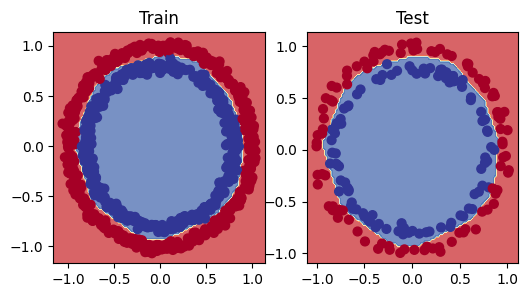

In [ ]:
model.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model(X_test))).squeeze()

plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model, X_test, y_test)


### Replicating non linear functions

In [ ]:
A = torch.arange(-10, 10, 1, dtype=torch.float32)

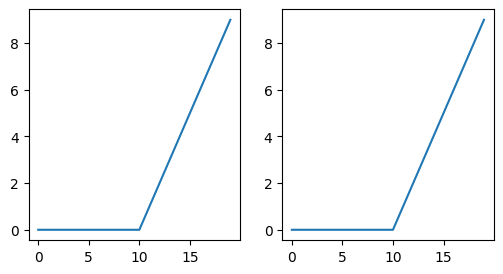

In [ ]:
def relu(x: torch.Tensor)-> torch.Tensor:
    return torch.maximum(torch.tensor(0), x)
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.plot(torch.relu(A))
plt.subplot(1,2,2)
plt.plot(relu(A))

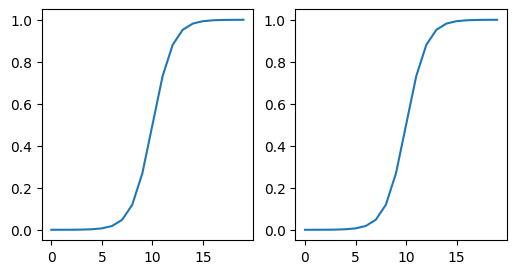

In [ ]:
def sigmoid(x):
    return 1 / (1 + torch.exp(-x))
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.plot(torch.sigmoid(A))
plt.subplot(1,2,2)
plt.plot(sigmoid(A))

### Putting it all together for MultiClass

In [ ]:
# Import dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
    n_features=NUM_FEATURES, # X features
    centers=NUM_CLASSES, # y labels 
    cluster_std=1.5, # give the clusters a little shake up (try changing this to 1.0, the default)
    random_state=RANDOM_SEED
)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
print(X_blob[:5], y_blob[:5])

# 3. Split into train and test sets
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
    y_blob,
    test_size=0.2,
    random_state=RANDOM_SEED
)

# 4. Plot data
# plt.figure(figsize=(10, 7))
# plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]]) tensor([3, 2, 2, 1, 1])


In [ ]:
# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

from torch import nn

# Build model
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        """Initializes all required hyperparameters for a multi-class classification model.

        Args:
            input_features (int): Number of input features to the model.
            out_features (int): Number of output features of the model
              (how many classes there are).
            hidden_units (int): Number of hidden units between layers, default 8.
        """
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=hidden_units, out_features=output_features), # how many classes are there?
        )
    
    def forward(self, x):
        return self.linear_layer_stack(x)

# Create an instance of BlobModel and send it to the target device
model_4 = BlobModel(input_features=NUM_FEATURES, 
                    output_features=NUM_CLASSES, 
                    hidden_units=8).to(device)

# Create loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_4.parameters(), 
                            lr=0.1) # exercise: try changing the learning rate here and seeing what happens to the model's performance

# Perform a single forward pass on the data (we'll need to put it to the target device for it to work)
model_4(X_blob_train.to(device))[:5]

# How many elements in a single prediction sample?
model_4(X_blob_train.to(device))[0].shape, NUM_CLASSES 

# Make prediction logits with model
y_logits = model_4(X_blob_test.to(device))

# Perform softmax calculation on logits across dimension 1 to get prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1) 

# Sum the first sample output of the softmax activation function 
torch.sum(y_pred_probs[0])

# Fit the model
torch.manual_seed(42)

# Set number of epochs
epochs = 100

# Put data to target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    ### Training
    model_4.train()

    # 1. Forward pass
    y_logits = model_4(X_blob_train) # model outputs raw logits 
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # go from logits -> prediction probabilities -> prediction labels
    # print(y_logits)
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_blob_train) 
    acc = accuracy_fn(y_true=y_blob_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_4.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_4(X_blob_test)
      test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
      # 2. Calculate test loss and accuracy
      test_loss = loss_fn(test_logits, y_blob_test)
      test_acc = accuracy_fn(y_true=y_blob_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%") 


Epoch: 0 | Loss: 1.15883, Acc: 40.38% | Test Loss: 0.81667, Test Acc: 68.50%


Epoch: 10 | Loss: 0.03970, Acc: 98.75% | Test Loss: 0.01952, Test Acc: 99.50%
Epoch: 20 | Loss: 0.03161, Acc: 99.25% | Test Loss: 0.00442, Test Acc: 100.00%
Epoch: 30 | Loss: 0.02219, Acc: 99.12% | Test Loss: 0.00606, Test Acc: 99.50%
Epoch: 40 | Loss: 0.01999, Acc: 99.50% | Test Loss: 0.00690, Test Acc: 99.50%
Epoch: 50 | Loss: 0.01866, Acc: 99.50% | Test Loss: 0.00842, Test Acc: 99.50%
Epoch: 60 | Loss: 0.01779, Acc: 99.50% | Test Loss: 0.00693, Test Acc: 100.00%
Epoch: 70 | Loss: 0.01723, Acc: 99.38% | Test Loss: 0.00528, Test Acc: 100.00%
Epoch: 80 | Loss: 0.01661, Acc: 99.38% | Test Loss: 0.00442, Test Acc: 100.00%
Epoch: 90 | Loss: 0.01617, Acc: 99.38% | Test Loss: 0.00472, Test Acc: 100.00%


In [ ]:
# Make predictions
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test)

# View the first 10 predictions
y_logits[:10]

tensor([[-18.3237,  21.5063, -52.0447, -39.1625],
        [  0.2761, -18.8128, -25.6506,   6.7659],
        [-44.4127, -50.4673,  38.5687,  -8.0357],
        [-22.6778,  24.1571, -40.0097, -36.0014],
        [  9.6104,  -8.1985, -36.7782, -11.9078],
        [ -0.6148, -22.5725, -30.3283,   9.1413],
        [-43.4761, -49.2270,  37.6196,  -7.8759],
        [  8.3179, -12.4780, -29.8828,  -4.9878],
        [-49.2035, -56.0149,  42.8069,  -8.9079],
        [  8.6234, -10.5103, -31.8065,  -7.5910]], device='cuda:0')

In [ ]:
# Turn predicted logits in prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)

# Turn prediction probabilities into prediction labels
y_preds = y_pred_probs.argmax(dim=1)

# Compare first 10 model preds and test labels
print(f"Predictions: {y_preds[:10]}\nLabels: {y_blob_test[:10]}")
print(f"Test accuracy: {accuracy_fn(y_true=y_blob_test, y_pred=y_preds)}%")

Predictions: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')
Labels: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')
Test accuracy: 100.0%


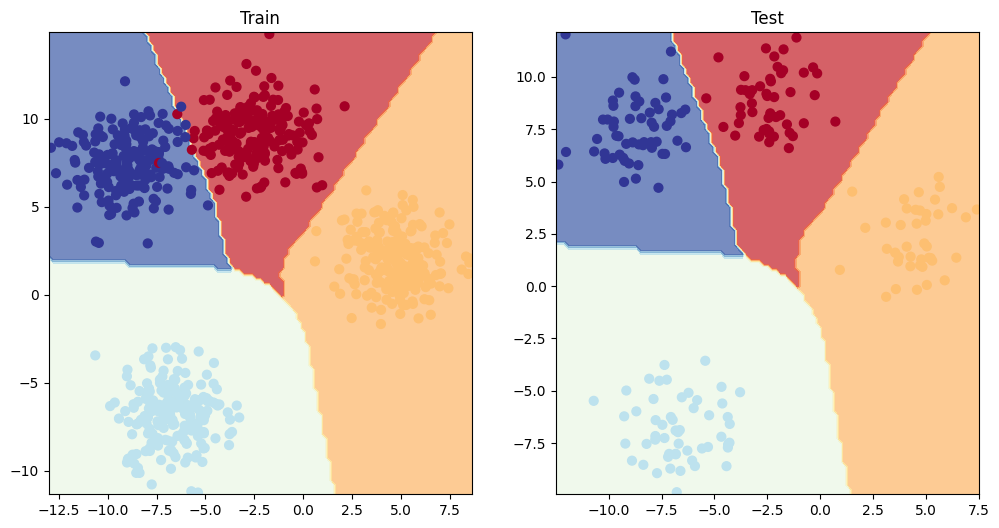

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

In [ ]:
from torchmetrics import Accuracy

# Setup metric and make sure it's on the target device
torchmetrics_accuracy = Accuracy(task='multiclass', num_classes=4).to(device)

# Calculate accuracy
torchmetrics_accuracy(y_preds, y_blob_test)

tensor(1., device='cuda:0')